[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3129
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 73
[LightGBM] [Info] Start training from score 12.030658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[331]	valid_0's l2: 0.0189801
Fold 1 RMSLE: 0.1378
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3125
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 74
[LightGBM] [Info] Start training from score 12.016898
Training until validation scores don't im

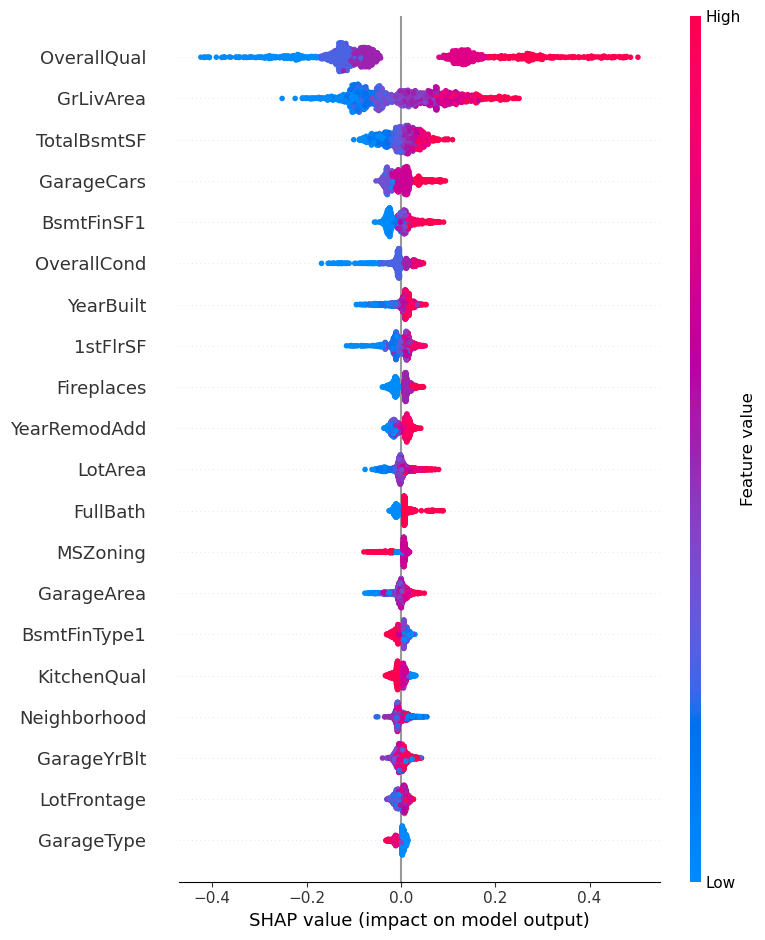

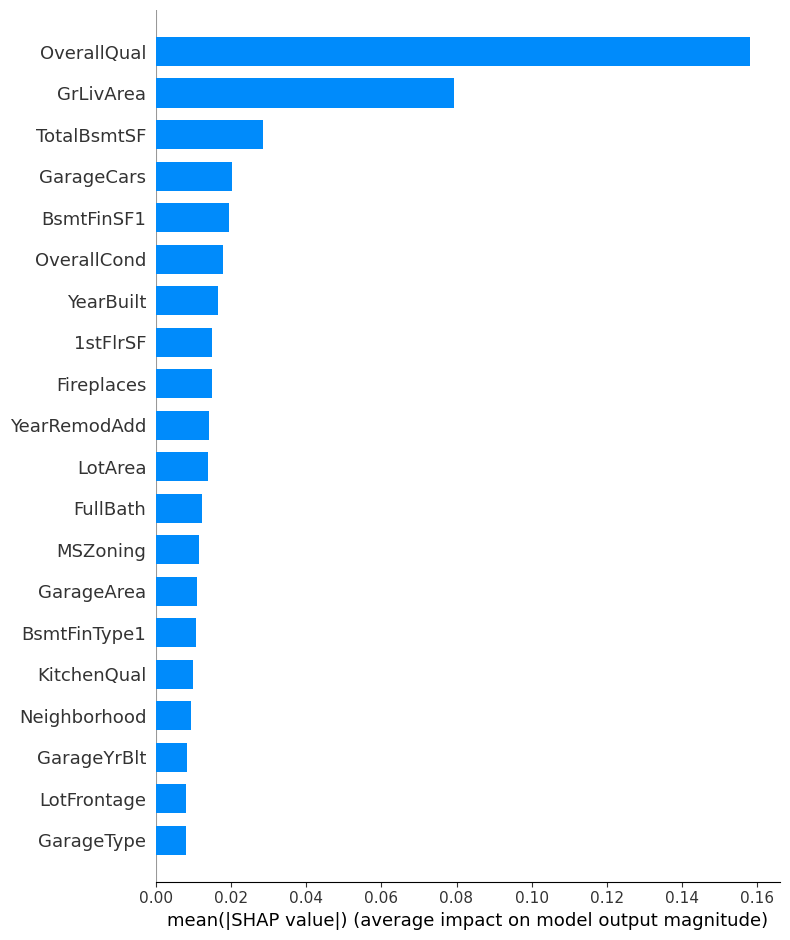

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt

# データ読み込み
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# RMSLE (Root Mean Squared Logarithmic Error) を計算する関数
def rmsle(y_true, y_pred):
    y_pred[y_pred < 0] = 0
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

# 評価関数（線形回帰）
def run_lgbm_cv(X, y, n_splits=5, random_state=42):
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds = np.zeros(len(X))
    cv_scores = []
    final_model = None

    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        y_train_log = np.log1p(y_train)
        y_val_log = np.log1p(y_val)

        model = lgb.LGBMRegressor(
            objective="regression", 
            learning_rate=0.05,
            num_leaves=31,
            n_estimators=10000,
            random_state=random_state
        )
        model.fit(X_train, y_train_log, 
                  eval_metric='rmsle', 
                  eval_set=[(X_val, y_val_log)],
                  callbacks=[lgb.early_stopping(50)]
                 )
        val_preds_log = model.predict(X_val, num_iteration=model.best_iteration_)

        val_preds = np.expm1(val_preds_log)
        oof_preds[val_idx] = val_preds
        score = rmsle(y_val, val_preds)
        cv_scores.append(score)
        print(f"Fold {fold+1} RMSLE: {score:.4f}")

        final_model = model

    cv_rmsle = np.mean(cv_scores)
    print(f"\nAverage CV labellgbm_RMSLE: {cv_rmsle:.4f}")
    
    return cv_rmsle, oof_preds, final_model

# SHAP値
def shap_analysis(model, X, max_display=20):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, max_display=max_display)
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_values, X, plot_type="bar", max_display=max_display)

    return shap_values

# モデルの学習と評価
X_train_all = train.drop(["Id","SalePrice"], axis=1)
X_test_all = test.drop(["Id"], axis=1)
y = train["SalePrice"]

combined = pd.concat([X_train_all, X_test_all], axis=0).reset_index(drop=True)
categorical_cols = combined.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    combined[col] = le.fit_transform(combined[col].astype(str).fillna('nan'))

X_train_processed = combined.iloc[:len(X_train_all), :]
X_test_processed = combined.iloc[len(X_train_all):, :]
    
cv_rmsle, oof_preds, lgbmmodel = run_lgbm_cv(X_train_processed, y)

Id_test = test[["Id"]]
y_test_pred_log = lgbmmodel.predict(X_test_processed)
y_test_pred = np.expm1(y_test_pred_log)

df_submission = pd.DataFrame({"Id":Id_test["Id"], "SalePrice":y_test_pred})
print(df_submission.head())
# df_submission.to_csv("submisson_baseline_labellgbm.csv", index = None)

# SHAP値の解析（上位20特徴量を表示）
shap_values = shap_analysis(lgbmmodel, X_train_processed, max_display=20)